# De novo design

### Developers: Mat Bieniek, Ben Cree, Rachael Pirie, Josh Horton

* Add R-groups in user-defined positions
* Output ADMET properties
* Perform constrained optimisation
* Score poses
* Send output to free energy calculations

Open source, customisable, fast/easy to use.

In [1]:
import copy
import glob
import prody
from rdkit import Chem
from rdkit.Chem import Draw
import pandas as pd
from rgroup import RMol, RList, build_molecules, fix_receptor, optimise_in_receptor, RGroups, sort_conformers, ic50

<frozen importlib._bootstrap>:228: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry const> already registered; second conversion method ignored.


In [2]:
%cd ~/rgroups/dat/p38/19jan
%pwd

/home/c0065492/rgroups/dat/p38/19jan


'/home/c0065492/rgroups/dat/p38/19jan'

In [3]:
prefix = 'lig_p38a_' #to extract experimental data from ligands.yml

In [4]:
!wget -nc https://files.rcsb.org/download/3FLY.pdb
pdb = '3FLY.pdb'

File ‘3FLY.pdb’ already there; not retrieving.



In [5]:
RMol.set_gnina(loc='/home/c0065492/software/gnina')

In [6]:
# load the complex with the ligand
sys = prody.parsePDB(pdb)
#sys = prody.parsePDB('jnk1/2gmx.pdb')

rec = sys.select('not (nucleic or hetatm) and not water')
#mol = sys.select('resname 19H and chain A')
mol = sys.select('resname 0X5')

prody.writePDB('rec.pdb', rec)
#prody.writePDB('lig.pdb', mol)

@> 3113 atoms and 1 coordinate set(s) were parsed in 0.04s.


'rec.pdb'

In [7]:
#!wget 'https://models.rcsb.org/v1/5nev/ligand?auth_seq_id=301&label_asym_id=E&encoding=sdf&filename=5nev_E_72L.sdf' -O lig.sdf
#!obabel jnk1/core.sdf -O jnk1/coreh.sdf -p 7
!obabel -isdf core.sdf -osdf -O coreh.sdf -p 7
# ^manually modify the files if need be
%pwd

1 molecule converted


'/home/c0065492/rgroups/dat/p38/19jan'

In [8]:
# load the ligand
# rdkit doesn't do a good job with protonation, 
#init_mol = Chem.MolFromPDBFile('lig.pdb', removeHs=False)
#init_mol = Chem.AddHs(init_mol, addCoords=True)

init_mol = Chem.SDMolSupplier('coreh.sdf', removeHs=False)[0]

# get the R group representation of the rdkit Mol
rinit_mol = RMol(init_mol)

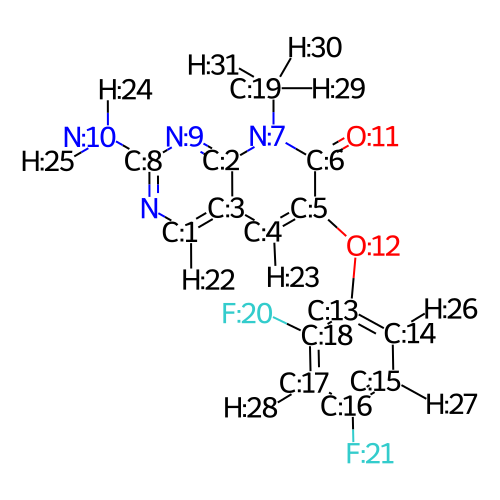

In [9]:
# select the atom to be replaced with the R group
rinit_mol.rep2D(idx=True, size=(500, 500))

In [10]:
#remove 44 since all conformers clash with protein
ligand_ids = ['2aa', '2bb', '2ee', '2gg', '2v', '2x', '2y', '2z', '3fln', '3flq', '3flw', '3fly', '3fmh', '3fmk']
len(ligand_ids)

14

In [11]:
#ligand_ids = ['13c', '13d', '13h', '17c', '17h']
# read the rgroups 1 by 1 in a loop
# assumes that there is only one -r.mol in each dir
rgroups = [Chem.MolFromMolFile(glob.glob(f'{ligand_id}/*.mol')[0], removeHs=False) for ligand_id in ligand_ids]
rgroups

In [12]:
# build a list of molecules
attachment_index = [25]
rmols = build_molecules(rinit_mol, attachment_index, rgroups)

Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7f84618ef040> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7f84618efee0>
Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7f84618efca0> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7f84618efbe0>
Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7f84618ef040> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7f84618efee0>
Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7f84618efca0> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7f84618efbe0>
Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7f84618efee0> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7f84618ef040>
Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7f84618efca0> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7f84618efbe0>
Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7f84618efee0> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7f84618ef040>
Rgroup atom index <rdkit.Chem.rdchem.QueryAtom o

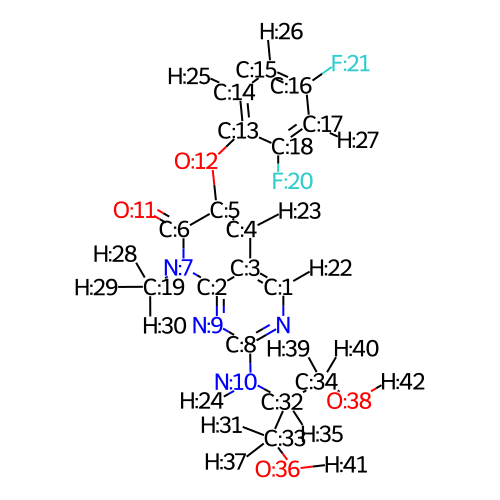

In [13]:
rmols[0].rep2D(idx=True, size=(500, 500))

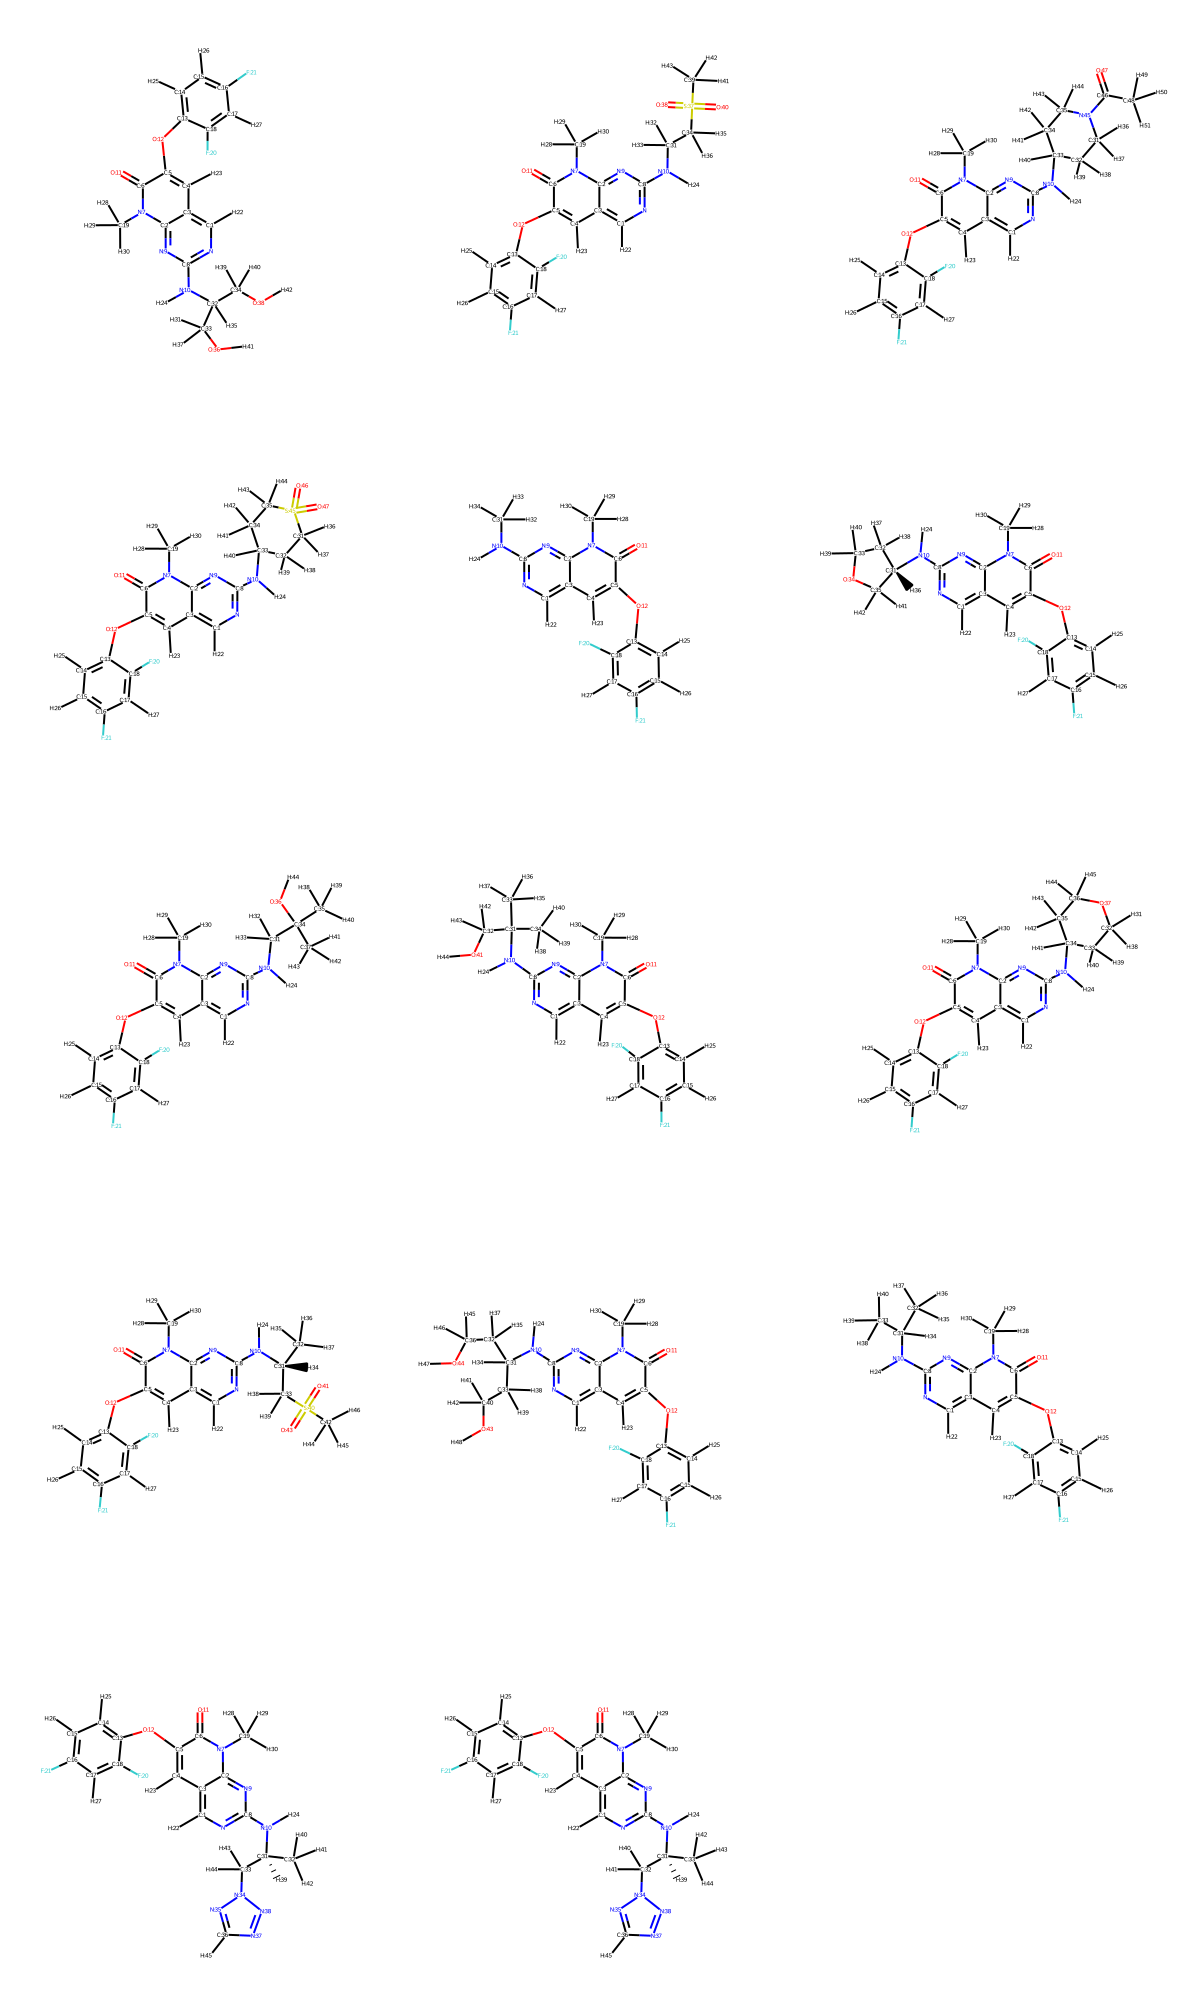

In [14]:
rmols.rep2D()

In [15]:
rmols[3].rep3D()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [16]:
rmols.toxicity()

MW  HBA  HBD    LogP  Pass_Ro5  has_pains  has_unwanted_subs  \
0  378.113961    8    3  1.1641      True      False              False   
0  410.086032    8    1  1.8555      True      False              False   
0  429.161246    7    1  2.8218      True      False              False   
0  436.101682    8    1  2.3881      True      False              False   
0  318.092832    6    1  2.4407      True      False              False   
0  374.119047    7    1  2.5998      True      False              False   
0  376.134697    7    2  2.5818      True      False              False   
0  376.134697    7    2  2.5818      True      False              False   
0  388.134697    7    1  2.9899      True      False              False   
0  424.101682    8    1  2.2440      True      False              False   
0  406.145262    8    3  1.9443      True      False              False   
0  346.124132    6    1  3.2193      True      False              False   
0  414.136428   10    1  1.8861      True      False              False   
0  414.136428   10    1  1.8861      True      False              False   

   has_prob_fgs  synthetic_accessibility  
0         False                 7.301823  
0         False                 7.117815  
0         False                 7.716864  
0         False                 7.437925  
0         False                 6.713426  
0         False                 7.681343  
0         False                 7.454900  
0         False                 7.474962  
0         False                 7.483120  
0         False                 7.762422  
0         False                 7.721059  
0         False                 7.210191  
0         False                 7.603684  
0         False                 7.603684

In [17]:
rmols.generate_conformers(num_conf=50,
                         minimum_conf_rms=0.5,
                         flexible = [10, 24]
                         )

RMol index 0
removed 10 duplicated conformations
RMol index 1
removed 7 duplicated conformations
RMol index 2
removed 3 duplicated conformations
RMol index 3
removed 8 duplicated conformations
RMol index 4
removed 46 duplicated conformations
RMol index 5
removed 38 duplicated conformations
RMol index 6
removed 10 duplicated conformations
RMol index 7
removed 14 duplicated conformations
RMol index 8
removed 20 duplicated conformations
RMol index 9
removed 3 duplicated conformations
RMol index 10
removed 1 duplicated conformations
RMol index 11
removed 30 duplicated conformations
RMol index 12
removed 26 duplicated conformations
RMol index 13
removed 23 duplicated conformations


In [18]:
#rmol.rep3D(template=True)

In [19]:
rmols.GetNumConformers()

[41, 44, 48, 43, 5, 13, 41, 37, 31, 48, 50, 21, 25, 28]

### Optimise conformers in context of protein

In [20]:
# fix the receptor file 
fix_receptor("rec.pdb", "rec_h.pdb")
# load back into prody
rec_fix = prody.parsePDB("rec_h.pdb")

@> 5593 atoms and 1 coordinate set(s) were parsed in 0.04s.


In [21]:
# filter by the protein clashes
rmols[2].rep3D(prody=rec_fix)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [22]:
rmols.removeConfsClashingWithProdyProt(rec_fix)

RMol index 0
Clash with the protein. Removing conformer id: 40
Clash with the protein. Removing conformer id: 39
Clash with the protein. Removing conformer id: 36
Clash with the protein. Removing conformer id: 35
Clash with the protein. Removing conformer id: 34
Clash with the protein. Removing conformer id: 33
Clash with the protein. Removing conformer id: 32
Clash with the protein. Removing conformer id: 31
Clash with the protein. Removing conformer id: 30
Clash with the protein. Removing conformer id: 29
Clash with the protein. Removing conformer id: 28
Clash with the protein. Removing conformer id: 27
Clash with the protein. Removing conformer id: 26
Clash with the protein. Removing conformer id: 25
Clash with the protein. Removing conformer id: 24
Clash with the protein. Removing conformer id: 23
Clash with the protein. Removing conformer id: 22
Clash with the protein. Removing conformer id: 21
Clash with the protein. Removing conformer id: 20
Clash with the protein. Removing conf

In [23]:
rmols.GetNumConformers()

[6, 8, 9, 4, 5, 3, 20, 1, 2, 2, 2, 7, 10, 9]

In [24]:
rmols[2].rep3D(prody=rec_fix)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [25]:
# opt_mol, energies
energies = rmols.optimise_in_receptor(
    receptor_file="rec_h.pdb", 
    ligand_force_field="openff", 
    use_ani=True,
    sigma_scale_factor=0.8,
    relative_permittivity=4
)

RMol index 0
using ani2x


Optimising conformer: 100%|███████████████████████| 6/6 [01:02<00:00, 10.43s/it]


RMol index 1
using ani2x


Optimising conformer: 100%|███████████████████████| 8/8 [07:25<00:00, 55.65s/it]


RMol index 2
using ani2x


Optimising conformer: 100%|███████████████████████| 9/9 [12:26<00:00, 82.98s/it]


RMol index 3
using ani2x


Optimising conformer: 100%|███████████████████████| 4/4 [04:34<00:00, 68.56s/it]


RMol index 4
using ani2x


Optimising conformer: 100%|███████████████████████| 5/5 [06:53<00:00, 82.74s/it]


RMol index 5
using ani2x


Optimising conformer: 100%|███████████████████████| 3/3 [02:13<00:00, 44.57s/it]


RMol index 6
using ani2x


Optimising conformer: 100%|█████████████████████| 20/20 [26:31<00:00, 79.56s/it]


RMol index 7
using ani2x


Optimising conformer: 100%|███████████████████████| 1/1 [00:05<00:00,  5.40s/it]


RMol index 8
using ani2x


Optimising conformer: 100%|███████████████████████| 2/2 [00:22<00:00, 11.11s/it]


RMol index 9
using ani2x


Optimising conformer: 100%|██████████████████████| 2/2 [07:23<00:00, 221.86s/it]


RMol index 10
using ani2x


Optimising conformer: 100%|███████████████████████| 2/2 [00:31<00:00, 15.64s/it]


RMol index 11
using ani2x


Optimising conformer: 100%|███████████████████████| 7/7 [00:52<00:00,  7.44s/it]


RMol index 12
using ani2x


Optimising conformer: 100%|█████████████████████| 10/10 [01:56<00:00, 11.61s/it]


RMol index 13
using ani2x


Optimising conformer: 100%|███████████████████████| 9/9 [01:50<00:00, 12.33s/it]


In [26]:
rmols[0].rep3D()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [27]:
for i in range(len(ligand_ids)):
    rmols[i].to_file("optimised_coords_" + str(ligand_ids[i]) + ".pdb")

In [28]:
final_energies = rmols.sort_conformers(energy_range=5)

RMol index 0
RMol index 1
RMol index 2
RMol index 3
RMol index 4
RMol index 5
RMol index 6
RMol index 7
RMol index 8
RMol index 9
RMol index 10
RMol index 11
RMol index 12
RMol index 13


In [29]:
len(ligand_ids) == len(rmols) #check theyre equal or very bad and silent things happen

True

In [5]:
for i in range(len(ligand_ids)):
    rmols[i].to_file("best_conformers_" + str(ligand_ids[i]) + ".pdb")

In [31]:
CNNscores = rmols.gnina(receptor_file="rec_h.pdb") 

RMol index 0
RMol index 1
RMol index 2
RMol index 3
RMol index 4
RMol index 5
RMol index 6
RMol index 7
RMol index 8
RMol index 9
RMol index 10
RMol index 11
RMol index 12
RMol index 13


In [32]:
ic50_scores = []
for i in range(len(CNNscores)):
    ic50_scores.append([ic50(x) for x in CNNscores[i]])

In [33]:
for i in range(len(ic50_scores)):
    with open('scores_' + str(ligand_ids[i]) + '.dat', 'w') as f:
        for x in range(len(ic50_scores[i])):
            f.write(str(ic50_scores[i][x])+'\n')

In [34]:
lowest = []
for i in range(len(ic50_scores)):
    lowest.append(ic50_scores[i][0])

In [35]:
import yaml
with open("ligands.yml", "r") as stream:
    try:
        data = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

experimental = []
for i in range(len(ligand_ids)):
    experimental.append(data[prefix+ str(ligand_ids[i])]['measurement']['value'])
experimental #for some reason no ic50 values only kJ/mol

[158, 223, 1, 15, 260, 31, 67, 25, 10, 50, 14, 4, 11, 2]

In [36]:
%pwd

'/home/c0065492/rgroups/dat/p38/19jan'

In [37]:
import pandas as pd

name = [ligand_ids[i:i+1] for i in range(0, len(ligand_ids), 1)]
energies = [i[0] for i in final_energies]
cnn = [i[0] for i in CNNscores]
ic50 = [i[0] for i in ic50_scores]
expt = [i for i in experimental]
output = pd.DataFrame({'ID' : name, 'Final energies' : energies, 'Gnina score' : cnn, 'Gnina IC50 / nM' : ic50, 'Experimental IC50 / nM' : expt})
output

ID  Final energies  Gnina score  Gnina IC50 / nM  \
0    [2aa]             0.0      6.96441       108.540046   
1    [2bb]             0.0      7.08383        82.446078   
2    [2ee]             0.0      7.45278        35.254942   
3    [2gg]             0.0      7.12278        75.373729   
4     [2v]             0.0      6.99110       102.070443   
5     [2x]             0.0      7.13493        73.294266   
6     [2y]             0.0      6.93874       115.148955   
7     [2z]             0.0      7.18410        65.448546   
8   [3fln]             0.0      7.15442        70.077726   
9   [3flq]             0.0      6.58330       261.035756   
10  [3flw]             0.0      6.76975       169.922152   
11  [3fly]             0.0      7.16445        68.477832   
12  [3fmh]             0.0      7.01298        97.055466   
13  [3fmk]             0.0      7.17728        66.484438   

    Experimental IC50 / nM  
0                      158  
1                      223  
2                        1  
3                       15  
4                      260  
5                       31  
6                       67  
7                       25  
8                       10  
9                       50  
10                      14  
11                       4  
12                      11  
13                       2

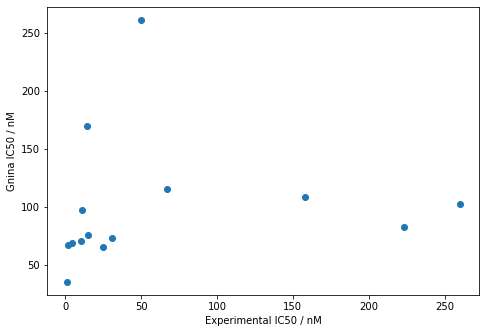

In [38]:
import matplotlib.pyplot as plt
import numpy as np

fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(expt, lowest) #, color='black', marker='x')
ax.set_xlabel('Experimental IC50 / nM')
ax.set_ylabel('Gnina IC50 / nM')

x = np.linspace(0,25,25)
y = np.linspace(50,350,25)



plt.savefig('out.png', bbox_inches='tight')
plt.show()

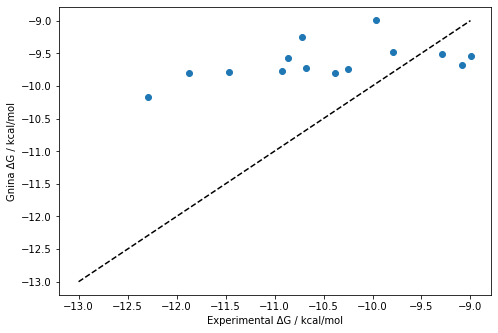

In [39]:
# convert nM to M
lowestinM = [ i * 1e-9 for i in lowest]
exptinM = [ i * 1e-9 for i in expt]

RT = 0.593 # kcal/mol

fig=plt.figure()
ax=fig.add_axes([0,0,1,1])

# DG = RTln(K)
ax.scatter(RT*np.log(exptinM), RT*np.log(lowestinM)) #, color='black', marker='x')
ax.set_xlabel('Experimental \u0394G / kcal/mol')
ax.set_ylabel('Gnina \u0394G / kcal/mol')

x = np.linspace(-13,-9,25)
ax.plot(x, x, color='black', linestyle='--')
A = np.vstack([experimental, np.ones(len(experimental))]).T
m, c = np.linalg.lstsq(A, lowest, rcond=None)[0]

m = "{:.2f}".format(m)
r = "r^2 =" + str(m)
plt.annotate(r, (-10,-6))
plt.savefig('deltaG2.png', bbox_inches='tight')
plt.show()

In [40]:
import re
smina_affinities = []
with open('smina_scores.dat', 'r') as f:
    for line in f:
        affinity = re.findall(r'Affinity: -?(-\d+.\d+)', str(line))
        try:
            smina_affinities.append(float(affinity[0]))
        except:
            pass

In [41]:
smina_affinities

[-7.61588,
 -5.90485,
 -8.607,
 -8.10013,
 -8.59826,
 -8.61313,
 -6.30607,
 -8.18225,
 -8.24187,
 -4.25658,
 -4.81333,
 -8.16663,
 -8.27064,
 -4.83341]

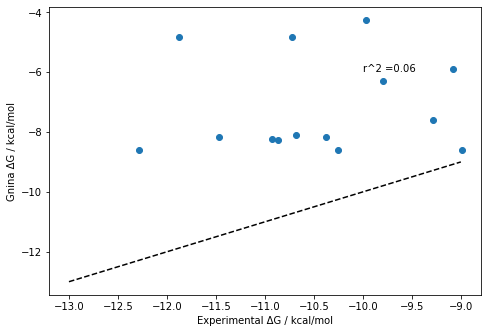

In [42]:
# convert nM to M
exptinM = [ i * 1e-9 for i in expt]

RT = 0.593 # kcal/mol

fig=plt.figure()
ax=fig.add_axes([0,0,1,1])

# DG = RTln(K)
ax.scatter(RT*np.log(exptinM), smina_affinities) #, color='black', marker='x')
ax.set_xlabel('Experimental \u0394G / kcal/mol')
ax.set_ylabel('Gnina \u0394G / kcal/mol')

x = np.linspace(-13,-9,25)
ax.plot(x, x, color='black', linestyle='--')
A = np.vstack([experimental, np.ones(len(experimental))]).T
m, c = np.linalg.lstsq(A, lowest, rcond=None)[0]

m = "{:.2f}".format(m)
r = "r^2 =" + str(m)
plt.annotate(r, (-10,-6))
plt.savefig('deltaG2_smina.png', bbox_inches='tight')
plt.show()

In [3]:
import dill
dill.load_session('notebook_p38.db')

In [4]:
CNNscores

[[6.96441, 6.6141],
 [7.08383],
 [7.45278, 7.26081, 7.23882, 7.06414],
 [7.12278, 7.43645],
 [6.9911, 6.99698],
 [7.13493],
 [6.93874, 7.14224],
 [7.1841],
 [7.15442],
 [6.5833, 6.48025],
 [6.76975],
 [7.16445, 6.97912, 6.97911, 6.97913, 6.9763, 6.97861, 6.97856],
 [7.01298, 7.47012, 7.177, 7.39539],
 [7.17728, 6.95828, 7.25349, 7.18189]]